# RFM Customer Segmentation using kMeans Algorithm

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples,silhouette_score

%matplotlib inline

In [2]:
df = pd.read_csv('Data\marketing_data.csv')
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Complain,Country
0,1826,1970,Graduation,Divorced,"$84,835.00",0,0,6/16/14,0,189,...,6,1,0,0,0,0,0,1,0,SP
1,1,1961,Graduation,Single,"$57,091.00",0,0,6/15/14,0,464,...,7,5,0,0,0,0,1,1,0,CA
2,10476,1958,Graduation,Married,"$67,267.00",0,1,5/13/14,0,134,...,5,2,0,0,0,0,0,0,0,US
3,1386,1967,Graduation,Together,"$32,474.00",1,1,5/11/14,0,10,...,2,7,0,0,0,0,0,0,0,AUS
4,5371,1989,Graduation,Single,"$21,474.00",1,0,4/8/14,0,6,...,2,7,1,0,0,0,0,1,0,SP


In [3]:
df.shape

(2240, 28)

In [4]:
df.columns

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', ' Income ',
       'Kidhome', 'Teenhome', 'Dt_Customer', 'Recency', 'MntWines',
       'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Response', 'Complain', 'Country'],
      dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   2240 non-null   int64 
 1   Year_Birth           2240 non-null   int64 
 2   Education            2240 non-null   object
 3   Marital_Status       2240 non-null   object
 4    Income              2216 non-null   object
 5   Kidhome              2240 non-null   int64 
 6   Teenhome             2240 non-null   int64 
 7   Dt_Customer          2240 non-null   object
 8   Recency              2240 non-null   int64 
 9   MntWines             2240 non-null   int64 
 10  MntFruits            2240 non-null   int64 
 11  MntMeatProducts      2240 non-null   int64 
 12  MntFishProducts      2240 non-null   int64 
 13  MntSweetProducts     2240 non-null   int64 
 14  MntGoldProds         2240 non-null   int64 
 15  NumDealsPurchases    2240 non-null   int64 
 16  NumWeb

In [6]:
df.isnull().sum()

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
 Income                24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Response                0
Complain                0
Country                 0
dtype: int64

In [7]:
df.duplicated().any()

False

# Data Cleaning and Feature Extraction

In [8]:
#cleaning income columns
df.rename(columns = {' Income ': 'Income'}, inplace = True)
df['Income'] = df['Income'].str.strip('$').str.replace(' ', '').str.replace(',', '')
df['Income'] = df['Income'].astype(float)
df['Income'] = df['Income'].fillna(df['Income'].median())

#convert datatypes from object to integer
df['Year_Birth'] = df['Year_Birth'].astype(int)

#convert datatypes from object to date
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'])
todayy = pd.Timestamp('28/2/21')
df['Dt_Customer'] = (todayy - df['Dt_Customer']).dt.days


#deleting absurd categories in marital status
delete_absurd = df[df['Marital_Status'] == 'Absurd'].index
df.drop(delete_absurd, inplace = True)

df['Education'] = df['Education'].str.replace('2n Cycle', 'Master')

df['Marital_Status'] = df['Marital_Status'].str.replace('YOLO', 'Single').str.replace('Alone', 
                                                                                      'Single').str.replace('Widow', 'Divorced')

df['Age'] = 2021 - df['Year_Birth']

df['Dependent'] = df['Kidhome'] + df['Teenhome']

spending_col = [col for col in df.columns if 'Mnt' in col]
df['Monetary'] = df[spending_col].sum(axis = 1)

platform_col = [col for col in df.columns if 'Purchases' in col]
df['Frequency'] = df[platform_col].sum(axis = 1)

df['Generation'] = df['Age'].\
apply(lambda x: 'Silent' if x > 76 else 'Boomers' if x > 56 else 'Gen X' if x > 41 else 'Milenial' if x > 27 else 'Gen Z')

col_to_drop = ['Kidhome', 'Teenhome']

df.drop(col_to_drop, axis = 1, inplace = True)

df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,...,AcceptedCmp1,AcceptedCmp2,Response,Complain,Country,Age,Dependent,Monetary,Frequency,Generation
0,1826,1970,Graduation,Divorced,84835.0,2449,0,189,104,379,...,0,0,1,0,SP,51,0,1190,15,Gen X
1,1,1961,Graduation,Single,57091.0,2450,0,464,5,64,...,0,1,1,0,CA,60,0,577,18,Boomers
2,10476,1958,Graduation,Married,67267.0,2483,0,134,11,59,...,0,0,0,0,US,63,1,251,11,Boomers
3,1386,1967,Graduation,Together,32474.0,2485,0,10,0,1,...,0,0,0,0,AUS,54,2,11,4,Gen X
4,5371,1989,Graduation,Single,21474.0,2518,0,6,16,24,...,0,0,1,0,SP,32,1,91,8,Milenial


# Let's Do It: RFM Segmentation

Text(0.2, 1, 'Checking Outlier by Boxplot')

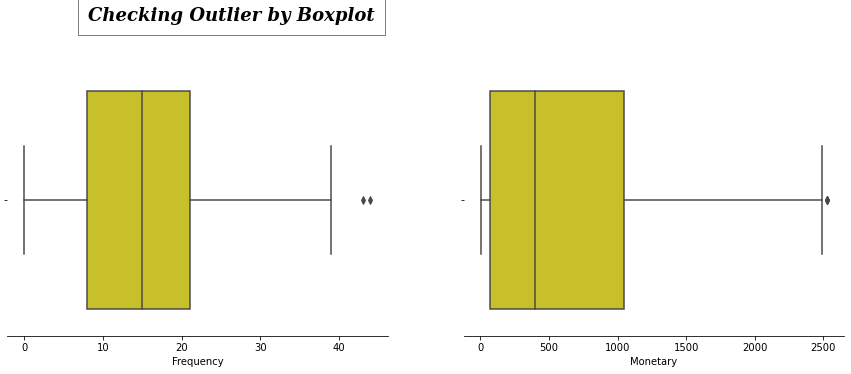

In [9]:
col_dist = ['Frequency', 'Monetary']
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax = ax.flatten()

for ind, col in enumerate(col_dist):
    sns.boxplot(x = df[col], ax = ax[ind], color = '#e2d810')
    for s in ['top', 'right', 'left']:
        ax[ind].spines[s].set_visible(False)
        
fig.text(0.2, 1, 'Checking Outlier by Boxplot', fontsize = 18, fontweight = 'bold', fontfamily = 'serif', color = 'black',
        bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10}, style = 'italic')

In [10]:
def determine_outlier_thresholds_iqr(data, col_name, th1=0.25, th3=0.75):
    quartile1 = data[col_name].quantile(th1)
    quartile3 = data[col_name].quantile(th3)
    iqr = quartile3 - quartile1
    upper_limit = quartile3 + 1.5 * iqr
    lower_limit = quartile1 - 1.5 * iqr
    return lower_limit, upper_limit
    
print(determine_outlier_thresholds_iqr(df, 'Frequency'))
print(determine_outlier_thresholds_iqr(df, 'Monetary'))

(-11.5, 40.5)
(-1395.0, 2507.0)


In [11]:
#Remove outlier

df_analysis = df.copy()
freq_outlier = df_analysis[(df_analysis['Frequency'] > 40.5)].index
mon_outlier = df_analysis[(df_analysis['Monetary'] > 2500)].index

df_analysis.drop(freq_outlier, axis = 0, inplace = True)
df_analysis.drop(mon_outlier, axis = 0, inplace = True)

df_analysis.shape

(2233, 31)

In [12]:
rfm_seg = df_analysis[['ID', 'Recency', 'Frequency', 'Monetary']]
no_sense = rfm_seg[(rfm_seg['Frequency'] <= 1)].index
rfm_seg.drop(no_sense, axis = 0, inplace = True)

rfm = rfm_seg.copy()
rfm.drop('ID', axis = 1, inplace = True)

rfm.shape

C:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


(2225, 3)

In [13]:
scaler = MinMaxScaler()
scaler.fit(rfm)
rfm_scaled = scaler.transform(rfm)

rfm_scaled = pd.DataFrame(rfm_scaled)
rfm_scaled.columns = ['Recency', 'Frequency', 'Monetary']
rfm_scaled.shape

(2225, 3)

Text(2, 300, 'Elbow Curve to Determine Number of Cluster')

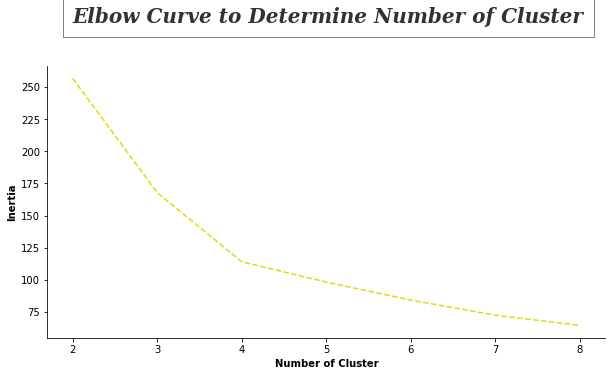

In [14]:
range_cluster = [k for k in range(2,9)]

cf = []

for clus in range_cluster:
    kmeans = KMeans(n_clusters = clus, random_state = 0, max_iter = 1000).fit(rfm_scaled)
    cf.append(kmeans.inertia_)

fig, ax = plt.subplots(1, 1, figsize = (10, 5))

ax.plot(range_cluster, cf, c = '#e2d810', linestyle = '--')
for s in ['top', 'right']:
        ax.spines[s].set_visible(False)

ax.set_xlabel('Number of Cluster', fontweight = 'bold')
ax.set_ylabel('Inertia', fontweight = 'bold', rotation = 90)

ax.text(2, 300, 'Elbow Curve to Determine Number of Cluster', fontsize = 20, fontfamily = 'serif', fontweight = 'bold', 
        color = '#323232', bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10}, style = 'italic')

For n_clusters = 2 The average silhouette_score is : 0.3663581763788576
For n_clusters = 3 The average silhouette_score is : 0.37447802952667236
For n_clusters = 4 The average silhouette_score is : 0.40070092785824557
For n_clusters = 5 The average silhouette_score is : 0.3654907386357602
For n_clusters = 6 The average silhouette_score is : 0.35877323516796816
For n_clusters = 7 The average silhouette_score is : 0.3508944480970756
For n_clusters = 8 The average silhouette_score is : 0.356307363101511


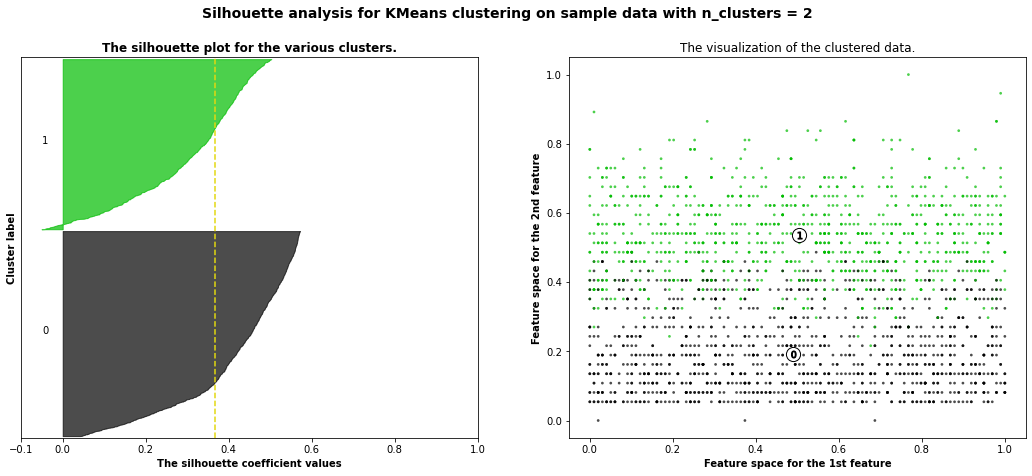

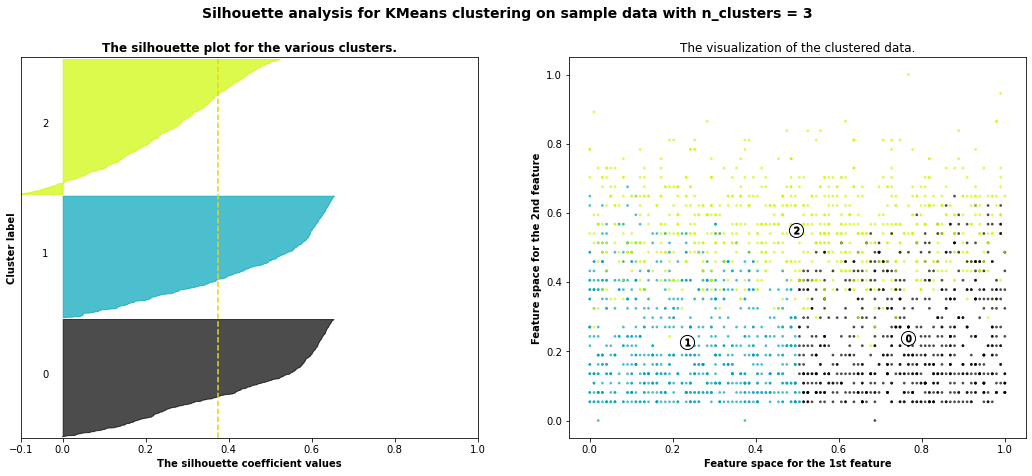

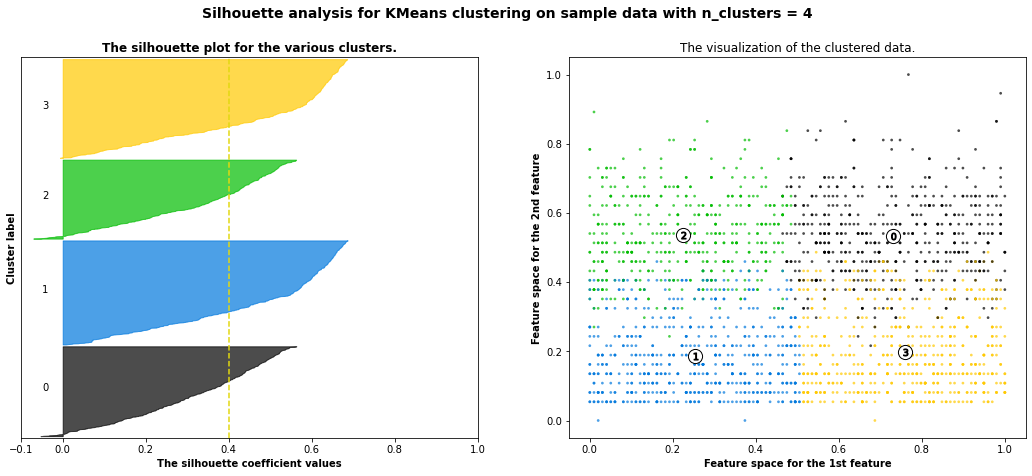

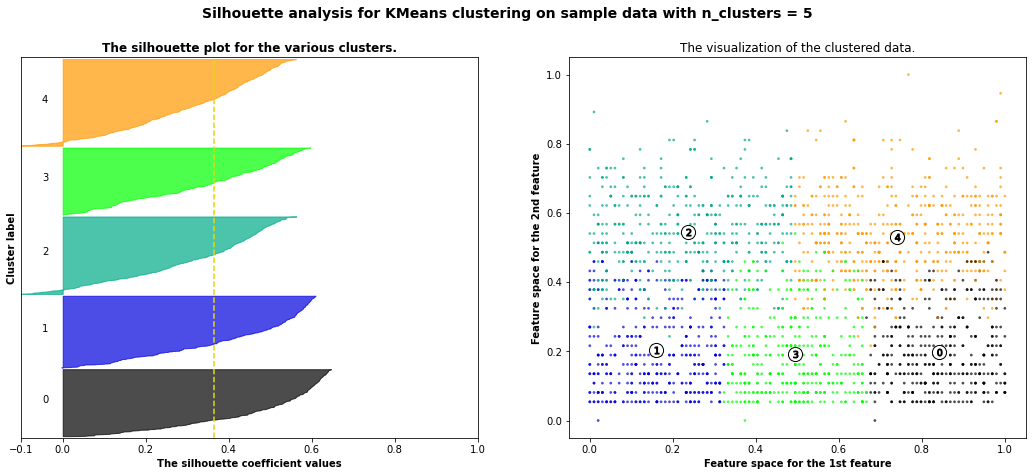

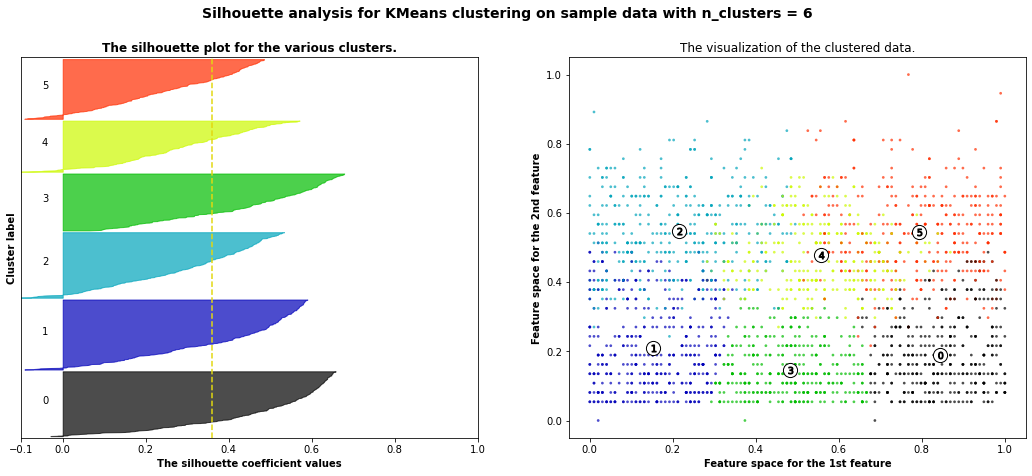

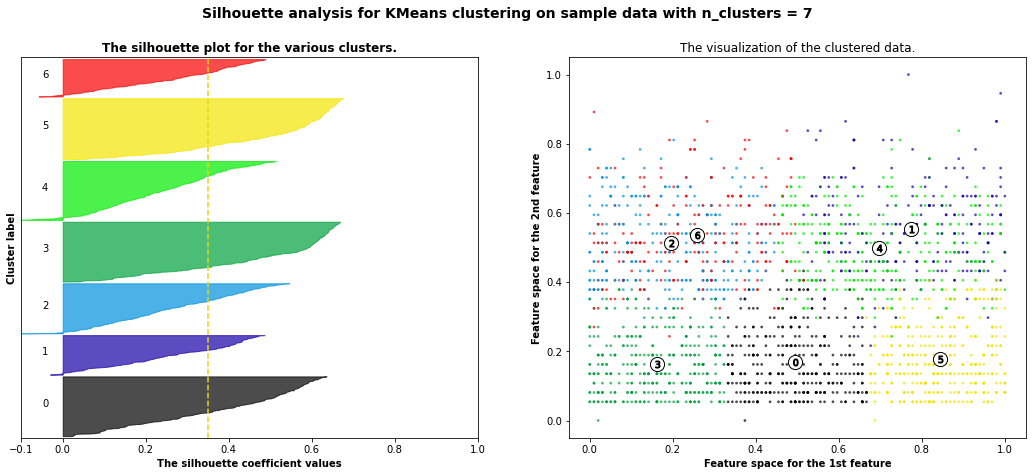

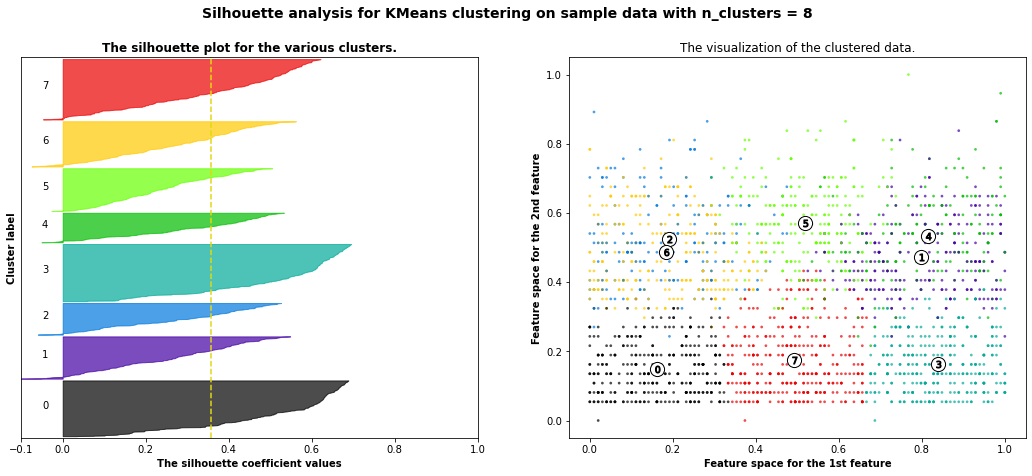

In [15]:
for clus in range_cluster:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(rfm_scaled) + (clus + 1) * 10])

    clusterer = KMeans(n_clusters = clus, random_state = 0)
    cluster_labels = clusterer.fit_predict(rfm_scaled)

    silhouette_avg = silhouette_score(rfm_scaled, cluster_labels)
    print("For n_clusters =", clus,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(rfm_scaled, cluster_labels)

    y_lower = 10
    for i in range(clus):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / clus)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor = color, edgecolor = color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title('The silhouette plot for the various clusters.', fontweight = 'bold')
    ax1.set_xlabel('The silhouette coefficient values', fontweight = 'bold')
    ax1.set_ylabel('Cluster label', fontweight = 'bold', rotation = 90)

    ax1.axvline(x = silhouette_avg, color = '#e2d810', linestyle = '--')

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / clus)
    ax2.scatter(rfm_scaled.iloc[:, 0], rfm_scaled.iloc[:, 1], marker='.', s = 30, lw = 0, alpha = 0.7,
                c = colors, edgecolor = 'k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker = 'o',
                c = "white", alpha = 1, s = 200, edgecolor = 'k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title('The visualization of the clustered data.')
    ax2.set_xlabel('Feature space for the 1st feature', fontweight = 'bold')
    ax2.set_ylabel('Feature space for the 2nd feature',  fontweight = 'bold', rotation = 90)

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % clus),
                 fontsize=14, fontweight='bold')

plt.show()

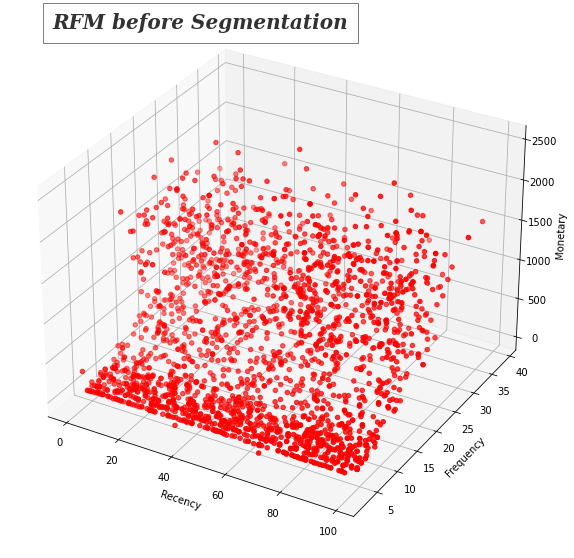

In [16]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')

x = rfm_seg['Recency']
y = rfm_seg['Frequency']
z = rfm_seg['Monetary']
ax.scatter(x, y, z, c = 'r', marker = 'o')

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

ax.text(0, 0, 4500, 'RFM before Segmentation', fontsize = 20, fontfamily = 'serif', fontweight = 'bold', color = '#323232',
       bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10}, style = 'italic')

plt.show()

In [17]:
#Since highest silhoutte score is on 4 cluster position, so we choose the number as well


#Run the Algorithm
kmeans = KMeans(n_clusters = 4,random_state = 0)
kmeans.fit(rfm_scaled)
rfm_seg['cluster'] = kmeans.labels_

<ipython-input-17-6d8064af4e5f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm_seg['cluster'] = kmeans.labels_


In [18]:
rfm_seg['Dt_Customer'] = df_analysis['Dt_Customer']
rfm_seg['Income'] = df_analysis['Income']

rfm_seg.groupby('cluster').agg({'cluster': 'count', 'Recency': 'mean','Frequency': 'mean', 'Monetary': 'mean', 'Income': 'mean',
                               'Dt_Customer': 'mean'}).round(2).sort_values('Monetary', ascending = False)

<ipython-input-18-62d147c860a4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm_seg['Dt_Customer'] = df_analysis['Dt_Customer']
<ipython-input-18-62d147c860a4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm_seg['Income'] = df_analysis['Income']


,cluster,Recency,Frequency,Monetary,Income,Dt_Customer
cluster,,,,,,
0,538,72.41,21.70,1179.92,69064.64,2827.56
2,473,22.18,21.89,1129.09,68911.28,2809.62
3,591,75.07,9.36,147.81,37784.34,2766.00
1,623,24.86,8.88,137.07,38216.12,2763.72


In [19]:
cluster_map = {0: 'Active', 1: 'Need Attention', 2: 'Loyal', 3: 'Less Priority'}
df_analysis['Segment'] = rfm_seg['cluster'].map(cluster_map)
df_analysis.head()

,ID,Year_Birth,Education,Marital_Status,Income,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,...,AcceptedCmp2,Response,Complain,Country,Age,Dependent,Monetary,Frequency,Generation,Segment
0,1826,1970,Graduation,Divorced,84835.0,2449,0,189,104,379,...,0,1,0,SP,51,0,1190,15,Gen X,Loyal
1,1,1961,Graduation,Single,57091.0,2450,0,464,5,64,...,1,1,0,CA,60,0,577,18,Boomers,Loyal
2,10476,1958,Graduation,Married,67267.0,2483,0,134,11,59,...,0,0,0,US,63,1,251,11,Boomers,Need Attention
3,1386,1967,Graduation,Together,32474.0,2485,0,10,0,1,...,0,0,0,AUS,54,2,11,4,Gen X,Need Attention
4,5371,1989,Graduation,Single,21474.0,2518,0,6,16,24,...,0,1,0,SP,32,1,91,8,Milenial,Need Attention


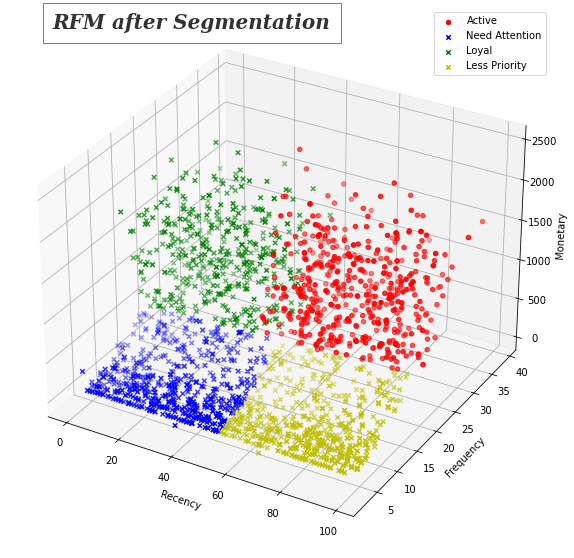

In [20]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection = '3d')

ax.scatter(rfm_seg['Recency'][rfm_seg['cluster'] == 0], rfm_seg['Frequency'][rfm_seg['cluster'] == 0], rfm_seg['Monetary'][rfm_seg['cluster'] == 0], c = 'r', marker = 'o')
ax.scatter(rfm_seg['Recency'][rfm_seg['cluster'] == 1], rfm_seg['Frequency'][rfm_seg['cluster'] == 1], rfm_seg['Monetary'][rfm_seg['cluster'] == 1], c = 'b', marker = 'x')
ax.scatter(rfm_seg['Recency'][rfm_seg['cluster'] == 2], rfm_seg['Frequency'][rfm_seg['cluster'] == 2], rfm_seg['Monetary'][rfm_seg['cluster'] == 2], c = 'g', marker = 'x')
ax.scatter(rfm_seg['Recency'][rfm_seg['cluster'] == 3], rfm_seg['Frequency'][rfm_seg['cluster'] == 3], rfm_seg['Monetary'][rfm_seg['cluster'] == 3], c = 'y', marker = 'x')

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

plt.legend(('Active','Need Attention', 'Loyal', 'Less Priority'))

ax.text(0, 0, 4500, 'RFM after Segmentation', fontsize = 20, fontfamily = 'serif', fontweight = 'bold', color = '#323232',
       bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10}, style = 'italic')

plt.show()

In [21]:
df_analysis.to_csv('marketing_EDA.csv')